In [1]:
import os
import pandas as pd
import numpy as np
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import joblib
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.metrics import RocCurveDisplay

In [4]:
os.chdir("../../Dataset/Merged")

Creazione Training e Test

In [5]:
dataset = pd.read_csv('MergedDatasetZeroes.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()
dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
print(dataset)

gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data
                                         SampleID      PatientID  Label  \
0                        0-GSM1026056_600009.0001  0-600009.0001      1   
1             0-GSM1026057_600009.0001-FollowUp_1  0-600009.0001      1   
2                         0-GSM1026058_41461.0001   0-41461.0001      1   
3                         0-GSM1026059_41462.0001   0-41462.0001      1   
4                        0-GSM1026060_600029.0001  0-600029.0001      1   
...                                           ...            ...    ...   
2108  6-GSM2347715_NT142_W18D2-Control-FollowUp_1  6-NT142_W18D2      0   
2109  6-GSM2347717_NT041_W18D2-Control-FollowUp_2  6-NT041_W18D2      0   
2110  6-GSM2347719_NT142_W18D2-Control-FollowUp_2  6-NT142_W18D2      0   
2111  6-GSM2347721_NT041_W18D2-Control-FollowUp_3  6-NT041_W18D2      0   
2112  6-GSM2347723_NT142_W18D2-Control-FollowUp_3  6-NT142_W18D2      0   

        STEEP1   SEC14L1     YIPF5    SLC1A5        C2      NOL6     SPRR3  \
0 

Caricamento modelli

In [5]:
svc = joblib.load('../../Modelli/DatasetZeroes/svc.pkl')
randomForest = joblib.load('../../Modelli/DatasetZeroes/randomForest.pkl')
elasticNet = joblib.load('../../Modelli/DatasetZeroes/elasticNet.pkl')
knn = joblib.load('../../Modelli/DatasetZeroes/knn.pkl')
HistgradientBoosting = joblib.load('../../Modelli/DatasetZeroes/HistGradientBoosting.pkl')
GradientBoosting = joblib.load('../../Modelli/DatasetZeroes/GradientBoosting.pkl')
naiveBayes = joblib.load('../../Modelli/DatasetZeroes/naiveBayes.pkl')

Modello Ensemble

In [6]:
newSvc = SVC(C=svc.best_params_['classifier__C'], kernel=svc.best_params_['classifier__kernel'], gamma=svc.best_params_['classifier__gamma'], probability=True)
newRandomForest = RandomForestClassifier(n_estimators=randomForest.best_params_['classifier__n_estimators'], max_depth=randomForest.best_params_['classifier__max_depth'])
newElasticNet = LogisticRegression(penalty=elasticNet.best_params_['classifier__penalty'], C=elasticNet.best_params_['classifier__C'], l1_ratio=elasticNet.best_params_['classifier__l1_ratio'], solver=elasticNet.best_params_['classifier__solver'])
newKnn = KNeighborsClassifier(n_neighbors=knn.best_params_['classifier__n_neighbors'], weights=knn.best_params_['classifier__weights'])
newHistGradientBoosting = HistGradientBoostingClassifier(learning_rate=HistgradientBoosting.best_params_['classifier__learning_rate'], max_iter=HistgradientBoosting.best_params_['classifier__max_iter'], max_depth=HistgradientBoosting.best_params_['classifier__max_depth'])
newGradientBoosting = GradientBoostingClassifier(learning_rate=GradientBoosting.best_params_['classifier__learning_rate'], n_estimators=GradientBoosting.best_params_['classifier__n_estimators'], max_depth=GradientBoosting.best_params_['classifier__max_depth'])
newNaiveBayes = GaussianNB();

In [ ]:
ensembleModel = VotingClassifier(estimators=[('svc', newSvc), ('randomForest', newRandomForest), ('HistGradientBoosting', newHistGradientBoosting), ('gradientBoosting', newGradientBoosting), ('naiveBayes', newNaiveBayes)], voting='hard')
ensemble = Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', ensembleModel)])
ensemble.fit(x_train, y_train)

In [11]:
ensemble = joblib.load('../../Modelli/DatasetZeroes/ensemble.pkl')
print("Ensemble model:")
print("Iperparametri: ", ensemble.named_steps['classifier'])
print("Training accuracy: ", ensemble.score(x_train, y_train))
print("Test accuracy: ", ensemble.score(x_test, y_test))
print(classification_report(y_test, ensemble.predict(x_test)))

Ensemble model:
Iperparametri:  VotingClassifier(estimators=[('svc',
                              SVC(C=8, gamma=0.0078125, probability=True)),
                             ('randomForest',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=225)),
                             ('HistGradientBoosting',
                              HistGradientBoostingClassifier(max_depth=5,
                                                             max_iter=200)),
                             ('gradientBoosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150)),
                             ('naiveBayes', GaussianNB())])
Training accuracy:  0.9711236660389203
Test accuracy:  0.9461538461538461
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       275
           1       0.91 

In [ ]:
weightSum = sum([model.best_score_ for model in [svc, randomForest, HistgradientBoosting, GradientBoosting]])
weightSum += naiveBayes.score(x_train, y_train)

weights = [model.best_score_ / weightSum for model in [svc, randomForest, HistgradientBoosting, GradientBoosting]]
weights.append(naiveBayes.score(x_train, y_train) / weightSum)

ensembleModelWeighted = VotingClassifier(estimators=[('svc', newSvc), ('randomForest', newRandomForest), ('HistgradientBoosting', newHistGradientBoosting), ('gradientBoosting', newGradientBoosting), ('naiveBayes', newNaiveBayes)],voting='soft', weights=weights, n_jobs=-1)
ensembleWeighted = Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', ensembleModelWeighted)])
ensembleWeighted.fit(x_train, y_train)

In [6]:
ensembleWeighted = joblib.load('../../Modelli/DatasetZeroes/ensembleWeighted.pkl')

print("Ensemble weighted model:")
print("Iperparametri: ", ensembleWeighted.named_steps['classifier'])
print("Training accuracy: ", ensembleWeighted.score(x_train, y_train))
print("Test accuracy: ", ensembleWeighted.score(x_test, y_test))
print(classification_report(y_test, ensembleWeighted.predict(x_test)))

Ensemble weighted model:
Iperparametri:  VotingClassifier(estimators=[('svc',
                              SVC(C=8, gamma=0.0078125, probability=True)),
                             ('randomForest',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=225)),
                             ('HistgradientBoosting',
                              HistGradientBoostingClassifier(max_depth=5,
                                                             max_iter=200)),
                             ('gradientBoosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150)),
                             ('naiveBayes', GaussianNB())],
                 n_jobs=-1, voting='soft',
                 weights=[0.1982020678948695, 0.19981223068107848,
                          0.20316438490954755, 0.20262906790686078,
                    

In [8]:
def applyEnsemble(x, models):
    Y_pred_proba_ensemble = [0 for i in range(len(x))]
    count = 0
    for i in range(len(models)):
        gs=models[i]
        count+=1
        Y_pred_proba = gs.predict_proba(x)
        Y_pred_proba_ensemble = [Y_pred_proba_ensemble[k] + Y_pred_proba[k, 1] for k in range(len(x))]
    Y_pred_proba_ensemble = np.array(Y_pred_proba_ensemble)
    Y_pred_proba_ensemble = Y_pred_proba_ensemble / count
    Y_pred_ensemble = (Y_pred_proba_ensemble > 0.5)*1
    return Y_pred_ensemble

In [9]:
models = [svc, randomForest, HistgradientBoosting, GradientBoosting, naiveBayes]
trainResult = applyEnsemble(x_train, models)
testResult = applyEnsemble(x_test, models)

In [ ]:
print("Manual ensemble model:")
print("Models: svc, randomForest, HistgradientBoosting, gradientBoosting, naiveBayes")
print("Training accuracy: ", sum(trainResult == y_train) / len(y_train))
print("Test accuracy: ", sum(testResult == y_test) / len(y_test))
print(classification_report(y_test, testResult))

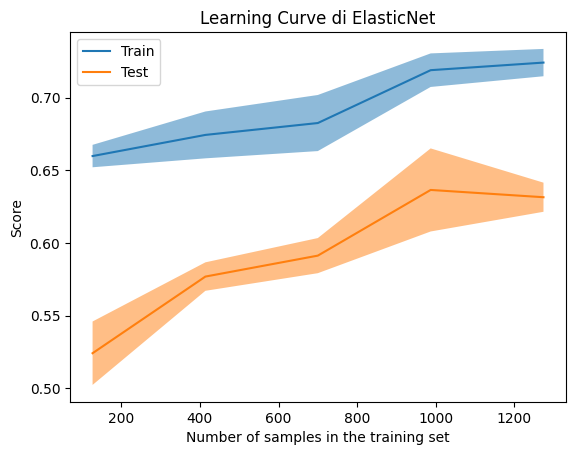

In [6]:
import warnings

warnings.filterwarnings("ignore")

train_sizes, train_scores, test_scores = learning_curve(elasticNet.best_estimator_, x_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.title("Learning Curve di ElasticNet")
plt.show()

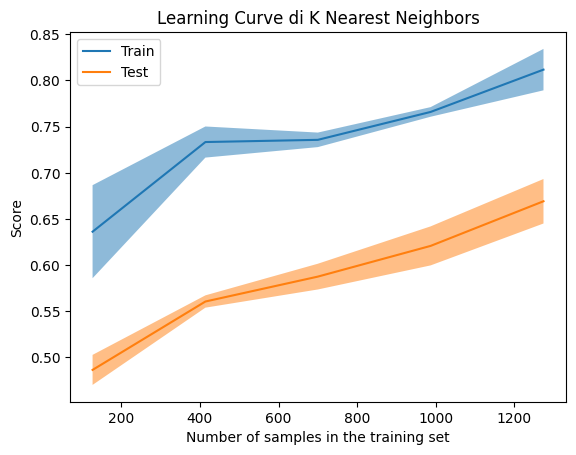

In [9]:
train_sizes, train_scores, test_scores = learning_curve(knn.best_estimator_, x_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.title("Learning Curve di K Nearest Neighbors")
plt.show()

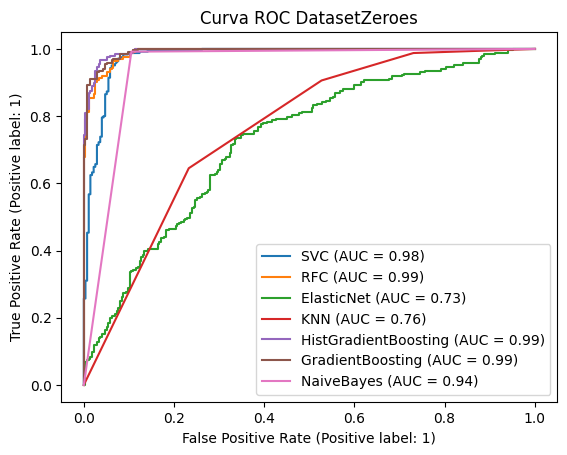

In [10]:
ax = plt.gca()
ax.set_title("Curva ROC DatasetZeroes")

svc_disp = RocCurveDisplay.from_estimator(svc, x_test, y_test, name="SVC", ax=ax)
rfc_disp = RocCurveDisplay.from_estimator(randomForest,  x_test, y_test, name="RFC", ax=ax)
elasticNet_disp = RocCurveDisplay.from_estimator(elasticNet,  x_test, y_test, name="ElasticNet", ax=ax)
knn_disp = RocCurveDisplay.from_estimator(knn,  x_test, y_test, name="KNN", ax=ax)
HistgradientBoosting_disp = RocCurveDisplay.from_estimator(HistgradientBoosting,  x_test, y_test, name="HistGradientBoosting", ax=ax)
gradientBoosting_disp = RocCurveDisplay.from_estimator(GradientBoosting,  x_test, y_test, name="GradientBoosting", ax=ax)
naiveBayes_disp = RocCurveDisplay.from_estimator(naiveBayes,  x_test, y_test, name="NaiveBayes", ax=ax)

In [7]:
ensembleSoft = VotingClassifier(estimators=[('svc', newSvc), ('randomForest', newRandomForest), ('HistGradientBoosting', newHistGradientBoosting), ('gradientBoosting', newGradientBoosting), ('naiveBayes', newNaiveBayes)], voting='soft')
ensemble = Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', ensembleSoft)])
ensemble.fit(x_train, y_train)
joblib.dump(ensemble, '../../Modelli/DatasetZeroes/ensembleSoft.pkl')

['../../Modelli/DatasetZeroes/ensembleSoft.pkl']

In [8]:
ensembleSoft = joblib.load('../../Modelli/DatasetZeroes/ensembleSoft.pkl')

print("Ensemble soft model:")
print("Iperparametri: ", ensembleSoft.named_steps['classifier'])
print("Training accuracy: ", ensembleSoft.score(x_train, y_train))
print("Test accuracy: ", ensembleSoft.score(x_test, y_test))
print(classification_report(y_test, ensembleSoft.predict(x_test)))

Ensemble soft model:
Iperparametri:  VotingClassifier(estimators=[('svc',
                              SVC(C=8, gamma=0.0078125, probability=True)),
                             ('randomForest',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=225)),
                             ('HistGradientBoosting',
                              HistGradientBoostingClassifier(max_depth=5,
                                                             max_iter=200)),
                             ('gradientBoosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150)),
                             ('naiveBayes', GaussianNB())],
                 voting='soft')
Training accuracy:  0.9893283113622097
Test accuracy:  0.948076923076923
              precision    recall  f1-score   support

           0       0.98      0.92      0.9

In [9]:
ensemble = joblib.load('../../Modelli/DatasetZeroes/ensemble.pkl')
ensembleSoft = joblib.load('../../Modelli/DatasetZeroes/ensembleSoft.pkl')
ensembleWeighted = joblib.load('../../Modelli/DatasetZeroes/ensembleWeighted.pkl')

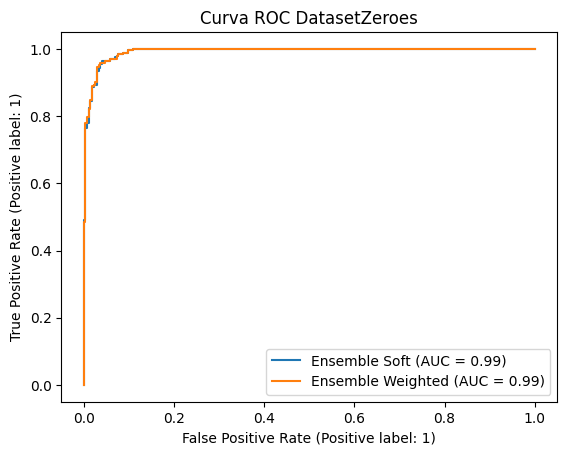

In [11]:
ax = plt.gca()
ax.set_title('Curva ROC DatasetZeroes')

ensembleSoft_disp = RocCurveDisplay.from_estimator(ensembleSoft, x_test, y_test, name="Ensemble Soft", ax=ax)
ensembleWeighted_disp = RocCurveDisplay.from_estimator(ensembleWeighted, x_test, y_test, name="Ensemble Weighted", ax=ax)

<h1> DatasetFull </h1>

| Modello                     | Iperparametri                                                                                                               | Training Accuracy | Test Accuracy | Precision | Recall | F1-score | Support |
|-----------------------------|-----------------------------------------------------------------------------------------------------------------------------|-------------------|---------------|-----------|--------|----------|---------|
| SVC                         | {'classifier__C': 128, 'classifier__gamma': 0.0078125, 'classifier__kernel': 'rbf'}                                      | 0.9448            | 0.95          | 0.95      | 0.95   | 0.95     | 520     |
| Random Forest               | {'classifier__max_depth': 9, 'classifier__n_estimators': 200}                                                             | 0.9347            | 0.9423        | 0.94      | 0.94   | 0.94     | 520     |
| Elastic Net                 | {'classifier__C': 0.5, 'classifier__l1_ratio': 1, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'} | 0.7062            | 0.6865        | 0.68      | 0.69   | 0.68     | 520     |
| KNN                         | {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}                                                          | 0.8920            | 0.8827        | 0.88      | 0.88   | 0.88     | 520     |
| Hist Gradient Boosting      | {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__max_iter': 200}                               | 0.9491            | 0.9538        | 0.95      | 0.95   | 0.95     | 520     |
| Gradient Boosting           | Pipeline(steps=[('Scaling', MinMaxScaler()), ('classifier', GradientBoostingClassifier(max_depth=5, n_estimators=150))])  | 1.0               | 0.9442        | 0.94      | 0.95   | 0.94     | 520     |
| Naive Bayes                 | Pipeline(steps=[('Scaling', MinMaxScaler()), ('classifier', GaussianNB())])                                               | 0.9153            | 0.9404        | 0.94      | 0.94   | 0.94     | 520     |
| Ensemble model              | VotingClassifier(estimators=[('svc', SVC(C=128, gamma=0.0078125, probability=True)), ...                                  | 1.0               | 0.95          | 0.95      | 0.95   | 0.95     | 520     |
| Ensemble weighted model     | VotingClassifier(estimators=[('svc', SVC(C=128, gamma=0.0078125, probability=True)), ...                                  | 1.0               | 0.9462        | 0.95      | 0.95   | 0.95     | 520     |
| Manual ensemble model       | Models: svc, randomForest, knn, HistgradientBoosting, gradientBoosting, naiveBayes                                         | 1.0               | 0.95          | 0.95      | 0.95   | 0.95     | 520     |


<h1> DatasetZeroes </h1>

| Modello                     | Iperparametri                                                                                                                               | Training Accuracy | Test Accuracy | Precision | Recall | F1-score | Support |
|-----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|-------------------|---------------|-----------|--------|----------|---------|
| SVC                         | {'classifier__C': 8, 'classifier__gamma': 0.0078125, 'classifier__kernel': 'rbf', 'classifier__probability': True}                        | 0.9278            | 0.9462        | 0.95      | 0.95   | 0.95     | 520     |
| Random Forest               | {'classifier__max_depth': 12, 'classifier__n_estimators': 225}                                                                           | 0.9353            | 0.9365        | 0.94      | 0.94   | 0.94     | 520     |
| Elastic Net                 | {'classifier__C': 0.5, 'classifier__l1_ratio': 1, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}                   | 0.6296            | 0.6404        | 0.67      | 0.63   | 0.61     | 520     |
| KNN                         | {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}                                                                          | 0.6692            | 0.6769        | 0.73      | 0.69   | 0.67     | 520     |
| Hist Gradient Boosting      | {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 200}                                             | 0.9510            | 0.9558        | 0.96      | 0.96   | 0.96     | 520     |
| Gradient Boosting           | {'classifier__learning_rate': 0.1, 'classifier__loss': 'log_loss', 'classifier__max_depth': 5, 'classifier__n_estimators': 150}       | 0.9485            | 0.95          | 0.95      | 0.95   | 0.95     | 520     |
| Naive Bayes                 | Pipeline(steps=[('Scaling', MinMaxScaler()), ('classifier', GaussianNB())])                                                             | 0.9184            | 0.9404        | 0.94      | 0.94   | 0.94     | 520     |
| Ensemble model              | VotingClassifier(estimators=[('svc', SVC(C=8, gamma=0.0078125, probability=True)), ...                                                     | 0.9711            | 0.9462        | 0.95      | 0.95   | 0.95     | 520     |
| Ensemble weighted model     | VotingClassifier(estimators=[('svc', SVC(C=8, gamma=0.0078125, probability=True)), ...                                                     | 0.9912            | 0.9481        | 0.95      | 0.95   | 0.95     | 520     |
| Manual ensemble model       | Models: svc, randomForest, HistgradientBoosting, gradientBoosting, naiveBayes                                                            | 0.9887            | 0.9481        | 0.95      | 0.95   | 0.95     | 520     |


<h1> DatasetReduced </h1>

| Modello                     | Iperparametri                                                                                                                    | Training Accuracy | Test Accuracy | Precision | Recall | F1-score | Support |
|-----------------------------|----------------------------------------------------------------------------------------------------------------------------------|-------------------|---------------|-----------|--------|----------|---------|
| SVC                         | {'classifier__C': 128, 'classifier__gamma': 0.0078125, 'classifier__kernel': 'rbf', 'classifier__probability': True}          | 0.9784            | 0.9526        | 0.95      | 0.95   | 0.95     | 464     |
| Random Forest               | {'classifier__max_depth': 12, 'classifier__n_estimators': 225}                                                                  | 0.9724            | 0.9353        | 0.94      | 0.94   | 0.94     | 464     |
| Elastic Net                 | {'classifier__C': 0.5, 'classifier__l1_ratio': 1, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}        | 0.7284            | 0.7672        | 0.76      | 0.73   | 0.74     | 464     |
| KNN                         | {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}                                                                 | 0.7970            | 0.7522        | 0.76      | 0.70   | 0.71     | 464     |
| Hist Gradient Boosting      | {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__max_iter': 100}                                    | 0.9784            | 0.9504        | 0.94      | 0.95   | 0.95     | 464     |
| Gradient Boosting           | {'classifier__learning_rate': 0.1, 'classifier__loss': 'log_loss', 'classifier__max_depth': 3, 'classifier__n_estimators': 200} | 0.9754            | 0.9418        | 0.94      | 0.94   | 0.94     | 464     |
| Naive Bayes                 | Pipeline(steps=[('Scaling', MinMaxScaler()), ('classifier', GaussianNB())])                                                    | 0.9239            | 0.9052        | 0.93      | 0.88   | 0.89     | 464     |
| Ensemble model              | VotingClassifier(estimators=[('svc', SVC(C=128, gamma=0.0078125, probability=True)), ...                                          | 1.0               | 0.9461        | 0.95      | 0.94   | 0.94     | 464     |
| Ensemble weighted model     | VotingClassifier(estimators=[('svc', SVC(C=128, gamma=0.0078125, probability=True)), ...                                          | 1.0               | 0.9483        | 0.95      | 0.95   | 0.95     | 464     |
| Manual ensemble model       | Models: svc, randomForest, HistgradientBoosting, gradientBoosting, naiveBayes                                                   | 1.0               | 0.9461        | 0.94      | 0.94   | 0.94     | 464     |


In [2]:
ensembleSoft = joblib.load('../../Modelli/DatasetZeroes/ensembleSoft.pkl')
rfe = joblib.load('../../ShapValues/DatasetZeroes/ensembleSoft_featureSelection.pkl')

In [6]:
keys_with_value = [key for key, value in rfe.items() if value > 0.96]
sorted_keys = sorted(keys_with_value, key=lambda x: len(x), reverse=True)
feature = sorted_keys[0]
print(len(feature))

1322


In [13]:
ensembleSoft.fit(x_train.filter(items=feature), y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 VotingClassifier(estimators=[('svc',
                                               SVC(C=8, gamma=0.0078125,
                                                   probability=True)),
                                              ('randomForest',
                                               RandomForestClassifier(max_depth=12,
                                                                      n_estimators=225)),
                                              ('HistGradientBoosting',
                                               HistGradientBoostingClassifier(max_depth=5,
                                                                              max_iter=200)),
                                              ('gradientBoosting',
                                               GradientBoostingClassifier(max_depth=5,
                                                                          n_estimators=150)),
                                              ('naiveBayes', GaussianNB())],
                                  voting='soft'))])

In [14]:
joblib.dump(ensembleSoft, '../../Modelli/DatasetZeroes/ensembleSelected_39.pkl')

['../../Modelli/DatasetZeroes/ensembleSelected_39.pkl']

In [13]:
ensembleSelected_39 = joblib.load('../../Modelli/DatasetZeroes/ensembleSelected_39.pkl')
x_train = x_train.filter(items=ensembleSelected_39.feature_names_in_)
x_test = x_test.filter(items=ensembleSelected_39.feature_names_in_)

In [14]:
print("Ensemble model reduced:")
print("Iperparametri: ", ensembleSelected_39.named_steps['classifier'])
print("Training accuracy: ", ensembleSelected_39.score(x_train, y_train))
print("Test accuracy: ", ensembleSelected_39.score(x_test, y_test))
print(classification_report(y_test, ensembleSelected_39.predict(x_test)))

Ensemble model reduced:
Iperparametri:  VotingClassifier(estimators=[('svc',
                              SVC(C=8, gamma=0.0078125, probability=True)),
                             ('randomForest',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=225)),
                             ('HistGradientBoosting',
                              HistGradientBoostingClassifier(max_depth=5,
                                                             max_iter=200)),
                             ('gradientBoosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150)),
                             ('naiveBayes', GaussianNB())],
                 voting='soft')
Training accuracy:  1.0
Test accuracy:  0.948076923076923
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       275


In [15]:
ensembleSelected_368 = joblib.load('../../Modelli/DatasetZeroes/ensembleSelected_368.pkl')
x_train = x_train.filter(items=ensembleSelected_368.feature_names_in_)
x_test = x_test.filter(items=ensembleSelected_368.feature_names_in_)

In [16]:
print("Ensemble model reduced:")
print("Iperparametri: ", ensembleSelected_368.named_steps['classifier'])
print("Training accuracy: ", ensembleSelected_368.score(x_train, y_train))
print("Test accuracy: ", ensembleSelected_368.score(x_test, y_test))
print(classification_report(y_test, ensembleSelected_368.predict(x_test)))

Ensemble model reduced:
Iperparametri:  VotingClassifier(estimators=[('svc',
                              SVC(C=8, gamma=0.0078125, probability=True)),
                             ('randomForest',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=225)),
                             ('HistGradientBoosting',
                              HistGradientBoostingClassifier(max_depth=5,
                                                             max_iter=200)),
                             ('gradientBoosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150)),
                             ('naiveBayes', GaussianNB())],
                 voting='soft')
Training accuracy:  1.0
Test accuracy:  0.948076923076923
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       275
